# Working with Hugging Face

Pixeltable provides seamless integration with Hugging Face datasets and models. This tutorial covers:

- Importing datasets directly into Pixeltable tables
- Working with dataset splits (train/test/validation)
- Streaming large datasets with `IterableDataset`
- Type mappings from Hugging Face to Pixeltable
- Using Hugging Face models for embeddings

## Setup

In [1]:
%pip install -qU pixeltable datasets torch transformers

Note: you may need to restart the kernel to use updated packages.


## Import a Hugging Face Dataset

Use `pxt.create_table()` with the `source=` parameter to import a Hugging Face dataset directly. Pixeltable automatically maps Hugging Face feature types to Pixeltable column types.

In [2]:
import pixeltable as pxt
import datasets

pxt.drop_dir('hf_demo', force=True)
pxt.create_dir('hf_demo')

# Load a dataset with images
padoru = (
    datasets.load_dataset("not-lain/padoru", split='train')
    .select_columns(['Image', 'ImageSize', 'Name', 'ImageSource'])
)

# Import into Pixeltable
images = pxt.create_table('hf_demo.images', source=padoru)

/opt/miniconda3/envs/pixeltable/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/pjlb/.pixeltable/pgdata
Created directory 'hf_demo'.
Created table 'images'.
Inserting rows into `images`: 100 rows [00:00, 324.25 rows/s]
Inserting rows into `images`: 100 rows [00:00, 376.68 rows/s]
Inserting rows into `images`: 100 rows [00:00, 380.44 rows/s]
Inserting rows into `images`: 82 rows [00:00, 601.72 rows/s]
Inserted 382 rows with 0 errors.


images.head(3)


Image,ImageSize,Name,ImageSource
,240993,AI-Chan,https://knowyourmeme.com/photos/1439336-padoru
,993097,Platelet,https://knowyourmeme.com/photos/1438687-padoru
,255549,Nezuko Kamado,https://knowyourmeme.com/photos/1568913-padoru

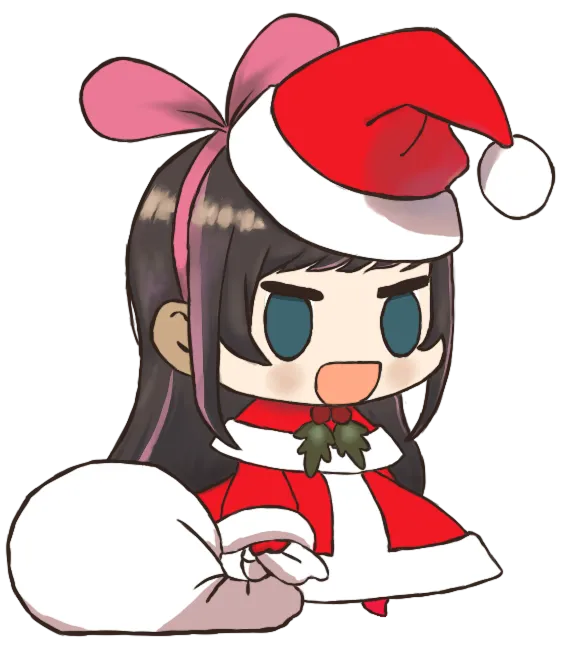
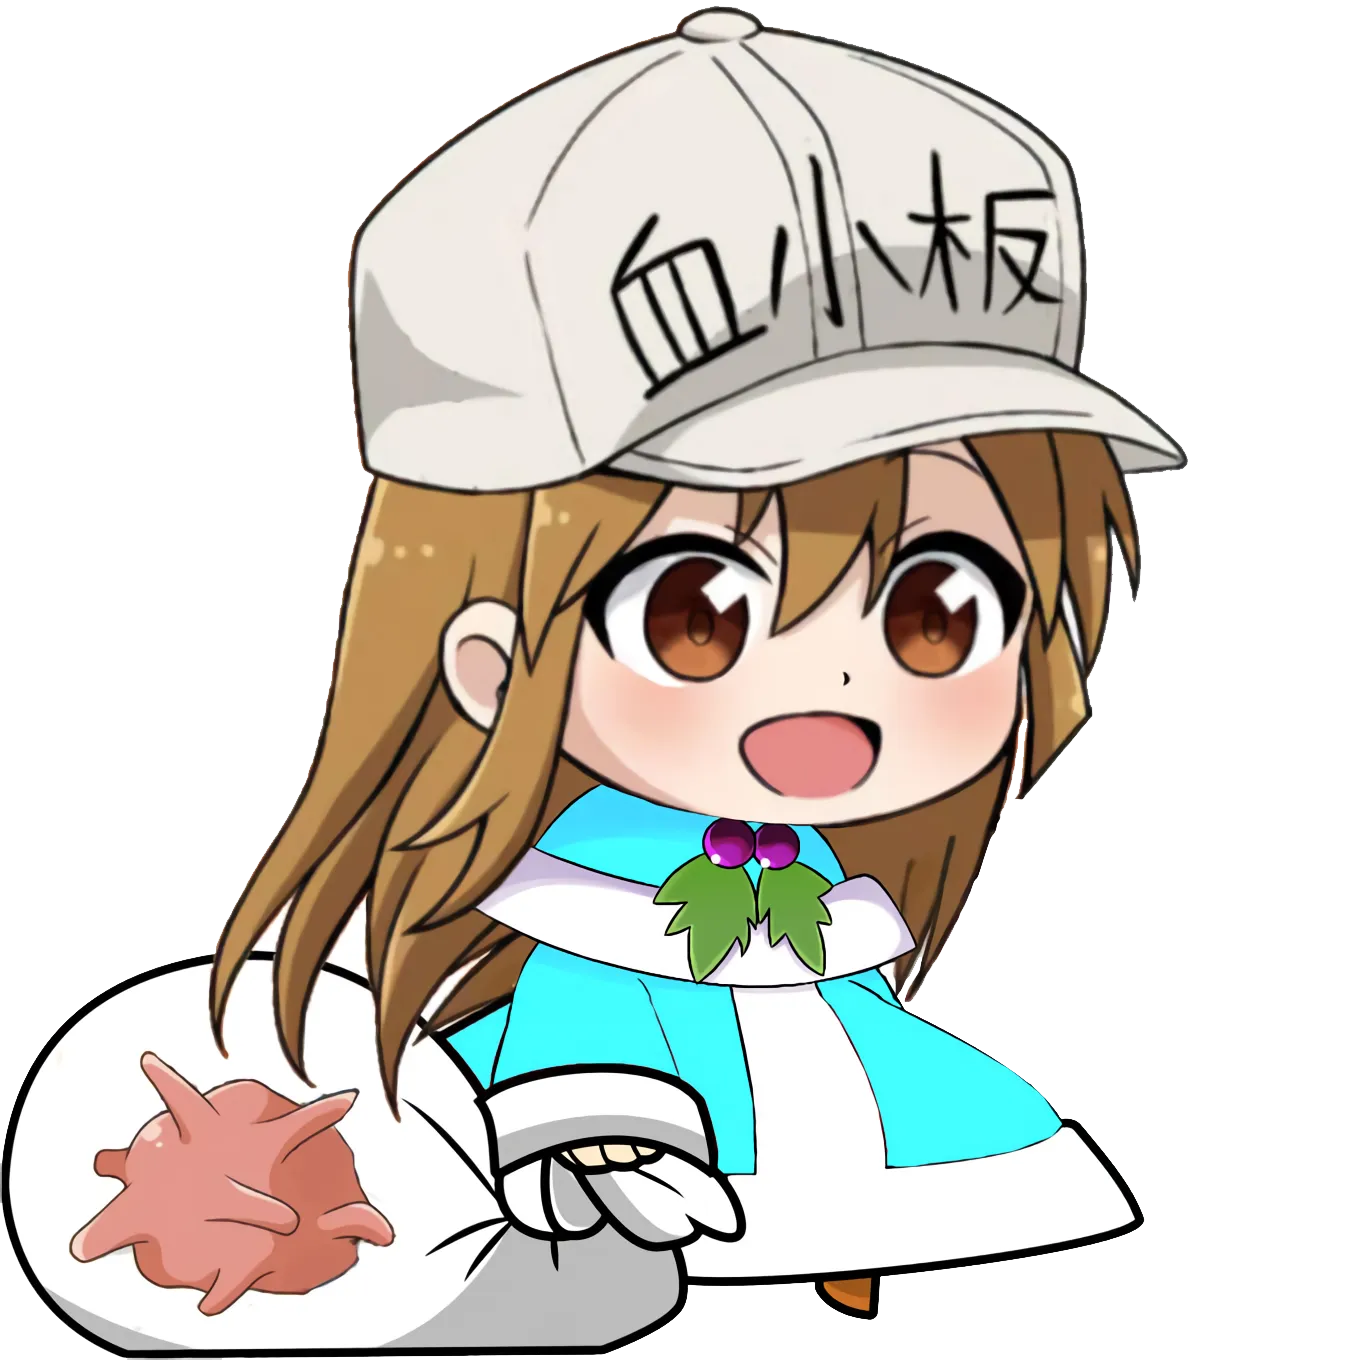
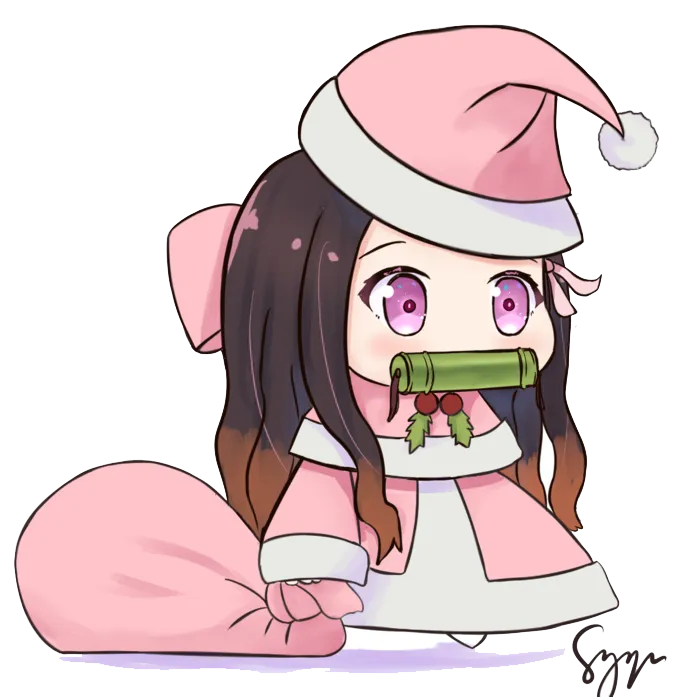

In [ ]:
## Working with Dataset Splits

When importing a `DatasetDict` (which contains multiple splits like train/test), use `extra_args={'column_name_for_split': 'split'}` to preserve split information in a column.

# Load a dataset with multiple splits
imdb = datasets.load_dataset('stanfordnlp/imdb')

# Import all splits, storing split info in 'split' column
reviews = pxt.create_table(
    'hf_demo.reviews',
    source=imdb,
    extra_args={'column_name_for_split': 'split'}
)

# Query by split
reviews.where(reviews.split == 'train').limit(3).select(reviews.text, reviews.label, reviews.split).collect()


In [ ]:
# Count rows per split
reviews.group_by(reviews.split).select(reviews.split, count=pxt.functions.count(reviews.text)).collect()

Created table 'reviews'.
Inserting rows into `reviews`: 1000 rows [00:00, 38570.09 rows/s]
Inserting rows into `reviews`: 1000 rows [00:00, 40839.16 rows/s]
Inserting rows into `reviews`: 1000 rows [00:00, 14984.21 rows/s]
Inserting rows into `reviews`: 1000 rows [00:00, 32792.34 rows/s]
Inserting rows into `reviews`: 1000 rows [00:00, 14834.33 rows/s]
Inserting rows into `reviews`: 1000 rows [00:00, 24843.36 rows/s]
Inserting rows into `reviews`: 1000 rows [00:00, 14553.30 rows/s]
Inserting rows into `reviews`: 1000 rows [00:00, 17313.59 rows/s]
Inserting rows into `reviews`: 1000 rows [00:00, 21856.60 rows/s]
Inserting rows into `reviews`: 1000 rows [00:00, 16946.55 rows/s]
Inserting rows into `reviews`: 1000 rows [00:00, 27734.60 rows/s]
Inserting rows into `reviews`: 1000 rows [00:00, 13725.09 rows/s]
Inserting rows into `reviews`: 1000 rows [00:00, 26511.16 rows/s]
Inserting rows into `reviews`: 1000 rows [00:00, 37265.81 rows/s]
Inserting rows into `reviews`: 1000 rows [00:00, 37

In [ ]:
## Using `schema_overrides` for Embeddings

When importing datasets with pre-computed embeddings (common in RAG), use `schema_overrides` to specify the exact array shape:

text,label,split
"I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered ""controversial"" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her at ...... edish cinema. Even Ingmar Bergman, arguably their answer to good old boy John Ford, had sex scenes in his films.<br /><br />I do commend the filmmakers for the fact that any sex shown in the film is shown for artistic purposes rather than just to shock people and make money to be shown in pornographic theaters in America. I AM CURIOUS-YELLOW is a good film for anyone wanting to study the meat and potatoes (no pun intended) of Swedish cinema. But really, this film doesn't have much of a plot.",neg,train
"""I Am Curious: Yellow"" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn't true. I've seen R-rated films with male nudity. Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia? Nowhere, because they don't exist. The same goes for those crappy cable shows ...... nudity, the mentally obtuse should take into account one unavoidably obvious anatomical difference between men and women: there are no genitals on display when actresses appears nude, and the same cannot be said for a man. In fact, you generally won't see female genitals in an American film in anything short of porn or explicit erotica. This alleged double-standard is less a double standard than an admittedly depressing ability to come to terms culturally with the insides of women's bodies.",neg,train
"If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).<br /><br />One might better spend one's time staring out a window at a tree growing.<br /><br />",neg,train


In [ ]:
# Wikipedia with pre-computed embeddings - specify array shape
wiki_ds = (
    datasets.load_dataset('Cohere/wikipedia-2023-11-embed-multilingual-v3', 'simple', split='train', streaming=True)
    .select_columns(['url', 'title', 'text', 'emb'])
    .take(50)
)

wiki = pxt.create_table(
    'hf_demo.wiki_embeddings',
    source=wiki_ds,
    schema_overrides={'emb': pxt.Array[(1024,), pxt.Float]}
)
wiki.select(wiki.title, wiki.emb).limit(2).collect()

split,count
test,25000
train,25000
unsupervised,50000


## Streaming Large Datasets

For very large datasets, use `streaming=True` to filter and sample before importing:

# Stream, filter, and sample before importing
streaming_ds = datasets.load_dataset('stanfordnlp/imdb', split='train', streaming=True)
positive_stream = streaming_ds.filter(lambda x: x['label'] == 1).take(50)

positive_samples = pxt.create_table('hf_demo.positive_samples', source=positive_stream)
positive_samples.select(positive_samples.text, positive_samples.label).limit(2).collect()


In [ ]:
## Importing Audio Datasets

Audio datasets work seamlessly - Pixeltable stores audio files locally:

In [ ]:
# Import a small audio dataset
audio_ds = datasets.load_dataset(
    'hf-internal-testing/librispeech_asr_dummy', 'clean', split='validation'
)

audio_table = pxt.create_table('hf_demo.audio_samples', source=audio_ds)
audio_table.select(audio_table.audio, audio_table.text).limit(2).collect()

In [ ]:
## Inserting More Data

Use `table.insert()` to add more data from a HuggingFace dataset to an existing table:

text,label
"Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I'd have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This movie is unrelentingly grim--""noir"" in more than one sense; one never sees the sun shine. Grim, but intriguing, and frightening.",pos
"Zentropa is the most original movie I've seen in years. If you like unique thrillers that are influenced by film noir, then this is just the right cure for all of those Hollywood summer blockbusters clogging the theaters these days. Von Trier's follow-ups like Breaking the Waves have gotten more acclaim, but this is really his best work. It is flashy without being distracting and offers the perfect combination of suspense and dark humor. It's too bad he decided handheld cameras were the wave of the future. It's hard to say who talked him away from the style he exhibits here, but it's everyone's loss that he went into his heavily theoretical dogma direction instead.",pos
"Lars Von Trier is never backward in trying out new techniques. Some of them are very original while others are best forgotten.<br /><br />He depicts postwar Germany as a nightmarish train journey. With so many cities lying in ruins, Leo Kessler a young American of German descent feels obliged to help in their restoration. It is not a simple task as he quickly finds out.<br /><br />His uncle finds him a job as a night conductor on the Zentropa Railway Line. His job is to attend to the needs o ...... clock. If you care to analyse the situation it is a completely impossible task. Quite ridiculous in fact. It could only happen in a dream.<br /><br />It's strange how one remembers little details such as a row of cups hanging on hooks and rattling away with the swaying of the train.<br /><br />Despite the fact that this film is widely acclaimed, I prefer Lars Von Trier's later films (Breaking the Waves and The Idiots). The bomb scene described above really put me off. Perhaps I'm a realist.",pos


# Insert more data from the same or similar dataset
more_audio = datasets.load_dataset(
    'hf-internal-testing/librispeech_asr_dummy', 'clean', split='validation'
).select(range(5))

before_count = audio_table.count()
audio_table.insert(more_audio)
f"Added {audio_table.count() - before_count} rows"


In [ ]:
## Type Mappings Reference

| HuggingFace Type | Pixeltable Type |
|------------------|------------------|
| `Value(bool)` | `Bool` |
| `Value(int*/uint*)` | `Int` |
| `Value(float*)` | `Float` |
| `Value(string)` | `String` |
| `Value(timestamp*)` | `Timestamp` |
| `ClassLabel` | `String` (label names) |
| `Sequence` of numerics | `Array` |
| `Array2D`-`Array5D` | `Array` (preserves shape) |
| `Image` | `Image` |
| `Audio` | `Audio` |
| `Video` | `Video` |
| Nested structures | `Json` |


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Image,Name,sim
,Glenn Litbeit,0.316
,Sayaka Miki,0.311
,Alucard,0.308

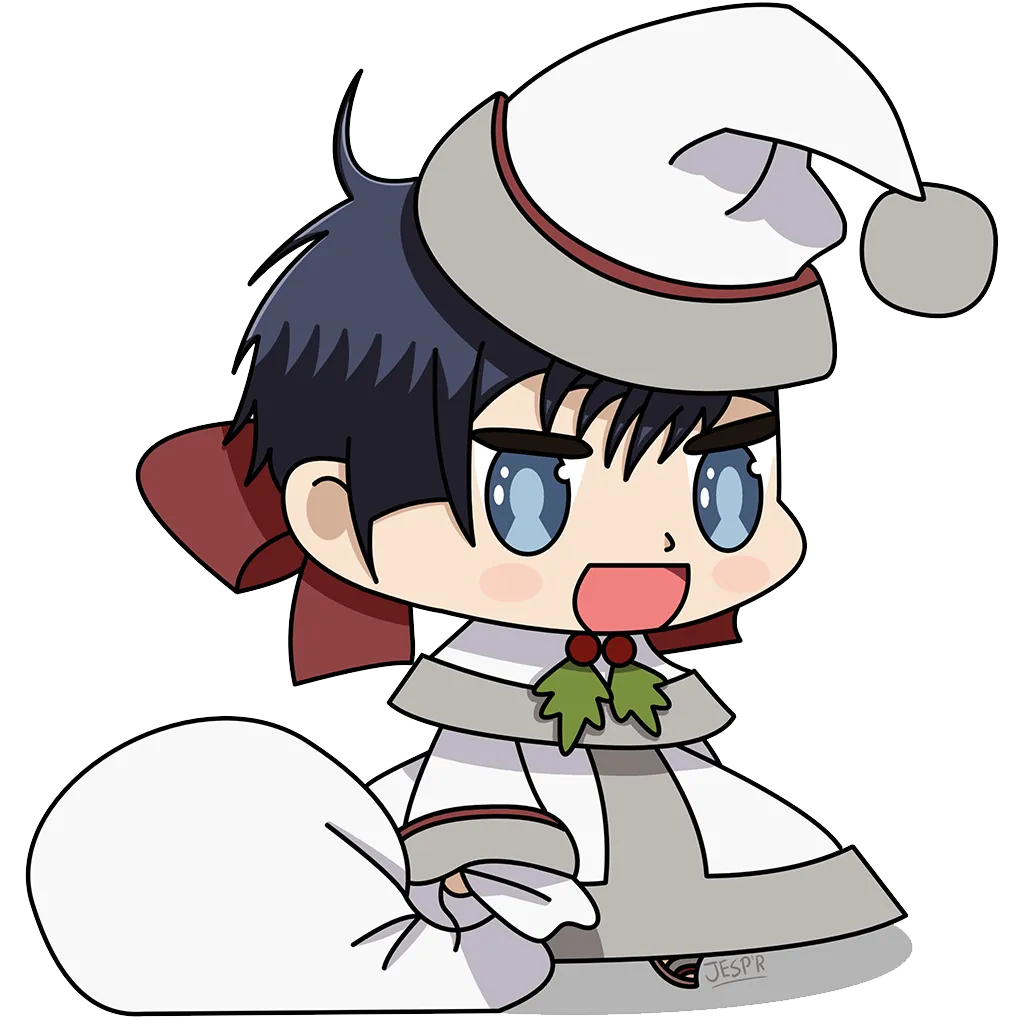
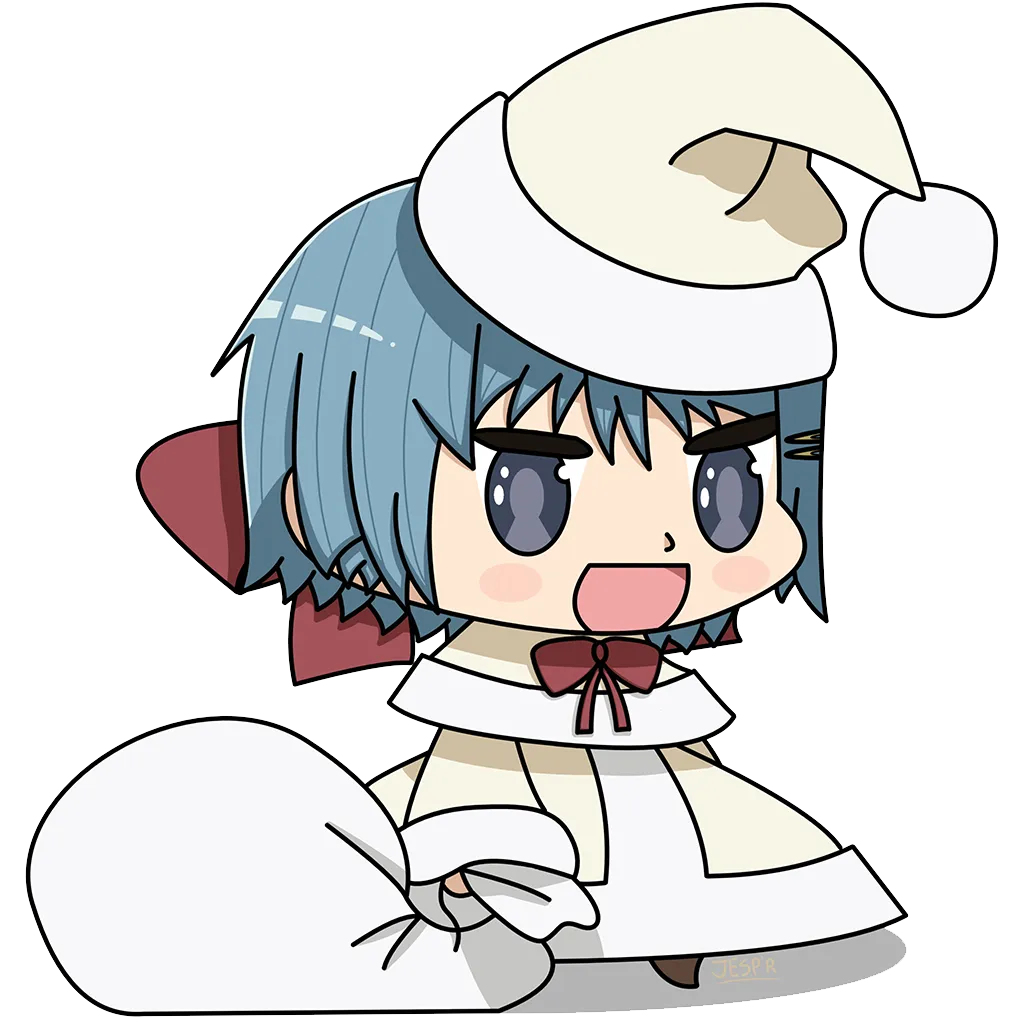
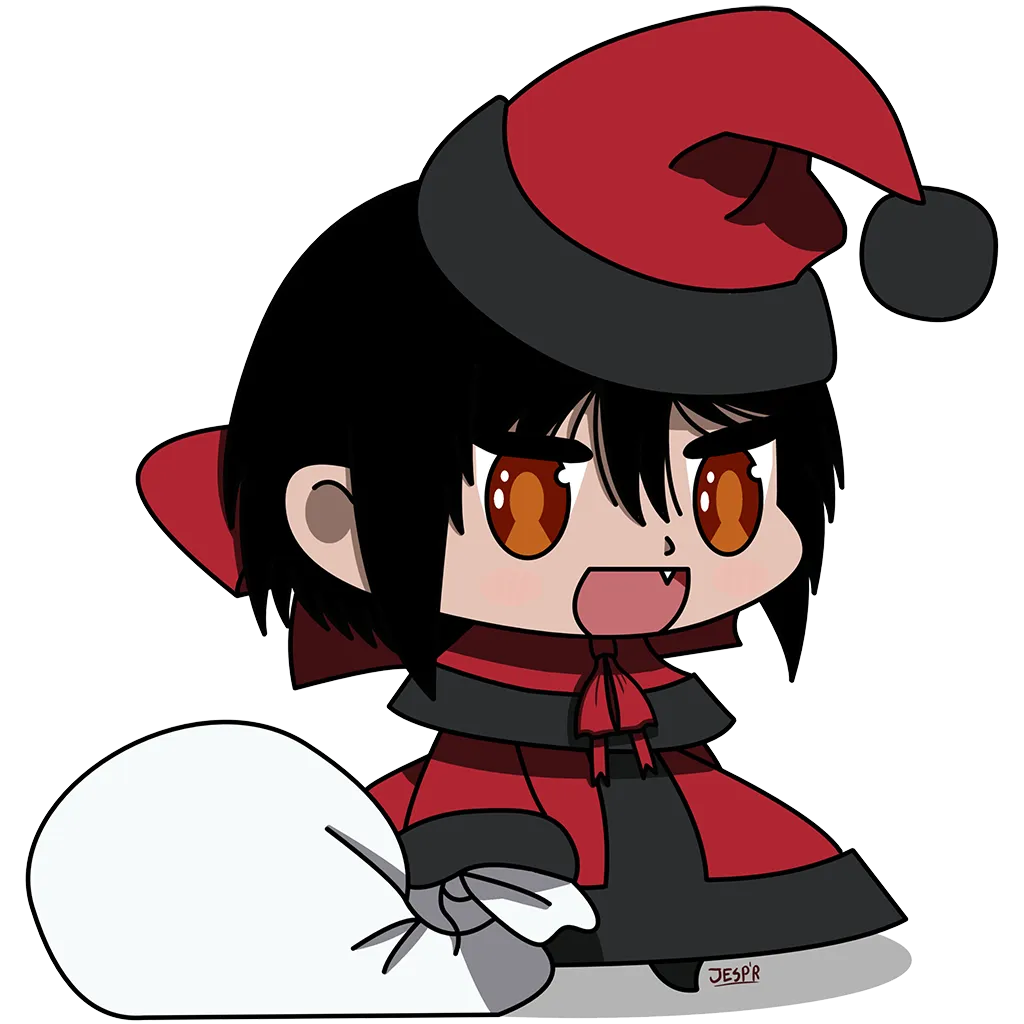

In [ ]:
## Using Hugging Face Models

Pixeltable integrates with Hugging Face models for embeddings and inference, running locally without API keys.

### Image Embeddings with CLIP


Image,Name,sim
,AI-Chan,1.
,Misaki Okusawa,0.96
,Ran Mitake,0.956

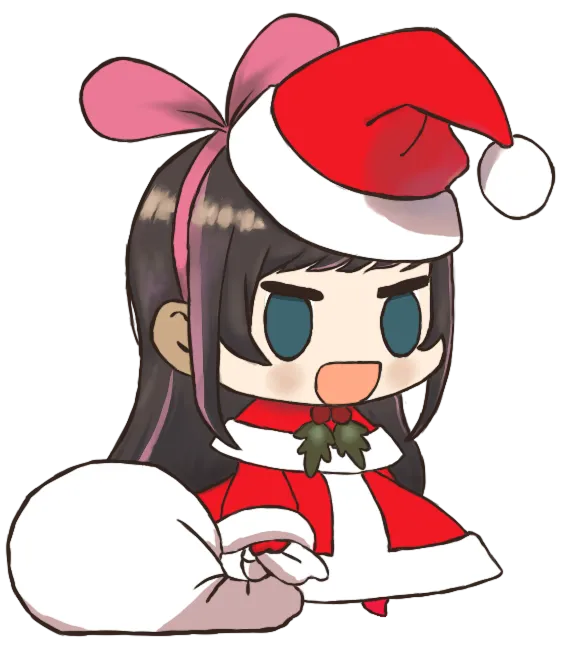
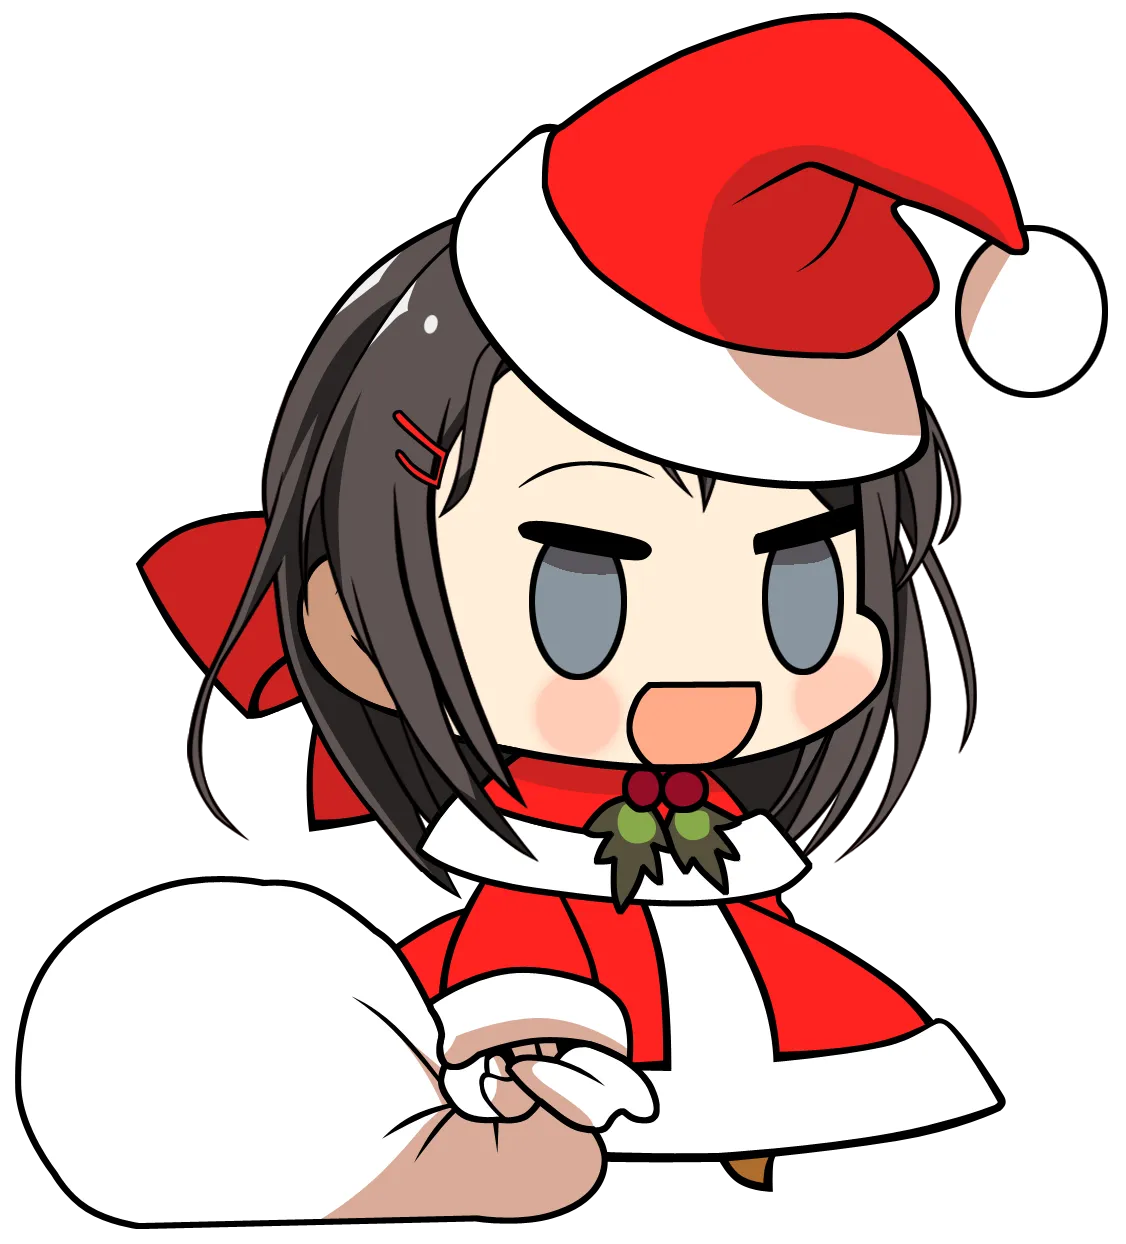
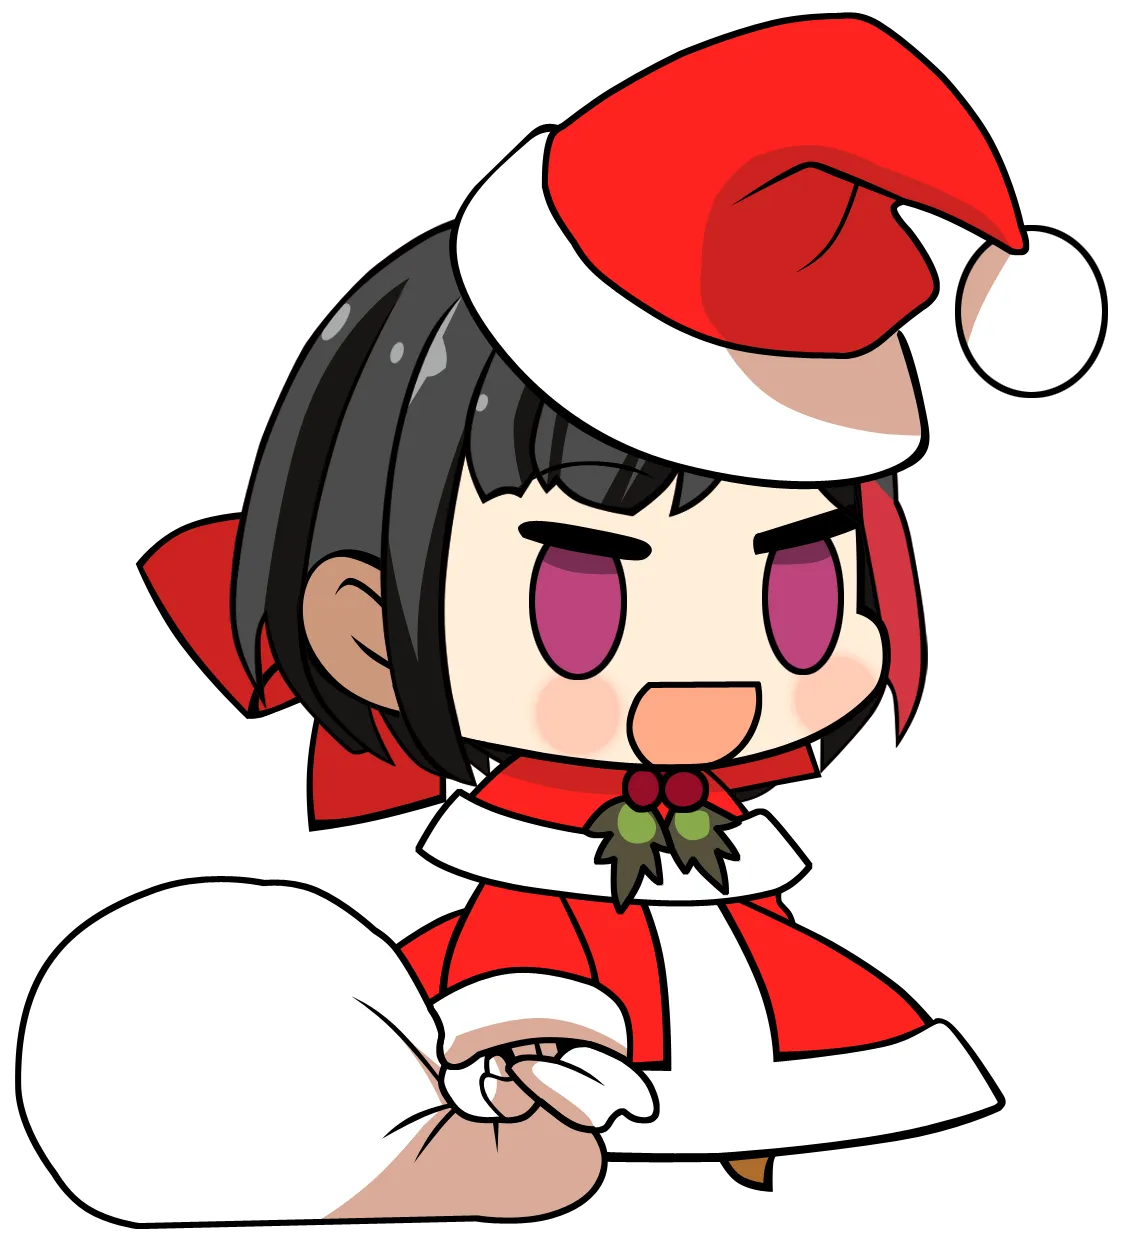

In [ ]:
from pixeltable.functions.huggingface import clip

# Add CLIP embedding index for cross-modal image search
images.add_embedding_index(
    'Image',
    embedding=clip.using(model_id='openai/clip-vit-base-patch32')
)

# Search images using text
sim = images.Image.similarity('anime character with red clothes')
images.order_by(sim, asc=False).limit(3).select(images.Image, images.Name, sim=sim).collect()


### Text Embeddings with Sentence Transformers


In [ ]:
from pixeltable.functions.huggingface import sentence_transformer

# Create table with text embedding index
sample_reviews = pxt.create_table(
    'hf_demo.sample_reviews',
    source=datasets.load_dataset('stanfordnlp/imdb', split='test').select(range(100))
)
sample_reviews.add_embedding_index('text', string_embed=sentence_transformer.using(model_id='all-MiniLM-L6-v2'))

# Semantic search
query = "great acting and cinematography"
sim = sample_reviews.text.similarity(query)
sample_reviews.order_by(sim, asc=False).limit(3).select(sample_reviews.text, sim=sim).collect()

Created table 'sample_reviews'.
Inserting rows into `sample_reviews`: 100 rows [00:00, 24813.96 rows/s]
Inserted 100 rows with 0 errors.


In [ ]:
### More Models: Classification, Detection, ASR, Translation

The SDK supports many more models. Here's object detection with DETR:


text,label,sim
"Maniratnam, who in India, is often compared with prominent world film makers and is regarded a genius in film-making, has yet again proved that he can only make the frames look visually good, without offering much food for thought.Forget about pure cinematic pleasure that can be derived from cinema as a very old form of art.<br /><br />While I would not like to claim and portray myself as someone who has seen all the beautiful movies made around the world, still any thoughtful and a bit educated film goer can identify that his films do not contain innovative ingenuous plots, does not contain lingering effects afterward and MOSTLY contain ridiculous ending and a LOT of melodrama, seen profusely in Indian movies.<br /><br />Overall, Maniratnam has successfully confirmed my distaste for his films once again.<br /><br />Sorry for those who on this board were claiming otherwise. My suggestion to you: WATCH SOME BEAUTIFUL CINEMAS MADE AROUND THE GLOBE.",neg,0.509
"I quite enjoyed The Wrecking Crew (1999), which was the last of the three films in this series (the first being Urban Menace (1999) which I've yet to see). I know it was baaaaad, but the three leads did a pretty decent job, all things considered.<br /><br />This, however, was truly atrocious. Ice-T was dreadful, and he's the producer! Can't say I've ever heard of Silkk The Shocker (who apparently never learnt how to spell), but his performance was one of the worst I've ever seen in a movie.< ...... io show after the SE Asian tsunami (plus other occasions sadly). Way to go, girl...<br /><br />No-one else comes out with any credit. Strangely, TJ Storm and Ernie Hudson (who are both pretty bad here) are far better in The Wrecking Crew, which was made, along with Urban Menace, at the same time as Corrupt. How that works, I don't know.<br /><br />I'm going to try the Ice-T commentary now, to see whether he apologises for the film, or tries to make us think it's a great piece of film-making.",neg,0.466
"Four things intrigued me as to this film - firstly, it stars Carly Pope (of ""Popular"" fame), who is always a pleasure to watch. Secdonly, it features brilliant New Zealand actress Rena Owen. Thirdly, it is filmed in association with the New Zealand Film Commission. Fourthly, a friend recommended it to me. However, I was utterly disappointed. The whole storyline is absurd and complicated, with very little resolution. Pope's acting is fine, but Owen is unfortunately under-used. The other actors and actresses are all okay, but I am unfamiliar with them all. Aside from the nice riddles which are littered throughout the movie (and Pope and Owen), this film isn't very good. So the moral of the story is...don't watch it unless you really want to.",neg,0.46


from pixeltable.functions.huggingface import detr_for_object_detection

# Object detection as computed column
images.add_computed_column(
    detections=detr_for_object_detection(images.Image, model_id='facebook/detr-resnet-50', threshold=0.7)
)
images.select(images.Image, images.detections).limit(1).collect()


In [ ]:
## See Also

- [HuggingFace SDK Reference](https://docs.pixeltable.com/sdk/latest/huggingface) - Full list of models: ASR, translation, text generation, image classification, etc.
- [Import Hugging Face datasets cookbook](https://docs.pixeltable.com/howto/cookbooks/data/data-import-huggingface) - More dataset examples
- [Working with embedding indexes](https://docs.pixeltable.com/tutorials/embedding-indexes) - Index configuration

Error: Error while evaluating computed column 'detections':
Unable to infer channel dimension format